In [1]:
import seaborn as sns
import numpy as np

from scipy.stats import poisson
import numpy as np
     

In [2]:
class Poisson(object):
    cache_pmf = {}
    cache_sf = {}
    cache = {}
    MAX_CUTOFF = 25

    @classmethod
    def pmf_series(cls, mu, cutoff):
        # Ensure that mu and cutoff are integers
        assert isinstance(mu, int), "mu should be an integer."
        assert isinstance(cutoff, int), "cutoff should be an integer"

        # If the Poisson PMF series for the given mu and cutoff isn't cached, calculate it
        if (mu, cutoff) not in cls.cache:
            cls._calculate_pmf_series(mu, cutoff)

        # Return the cached result
        return cls.cache[(mu, cutoff)]

    @classmethod
    def _calculate_pmf_series(cls, mu, cutoff):
        # If the Poisson PMF for the given mu hasn't been computed yet, calculate it
        if mu not in cls.cache_pmf:
            print("Calculating Poisson PMF ...")
            cls.cache_pmf[mu] = poisson.pmf(np.arange(cls.MAX_CUTOFF + 1), mu)
            cls.cache_sf[mu] = poisson.sf(np.arange(cls.MAX_CUTOFF + 1), mu)

        # Copy the PMF values up to the given cutoff
        out = np.copy(cls.cache_pmf[mu][:cutoff+1])
        # Add the survival function value for the cutoff
        out[-1] += cls.cache_sf[mu][cutoff]

        # Cache the result for future use
        cls.cache[(mu, cutoff)] = out


# Value Iteration Algorithm for Bike Rental Problem

## Problem Definition

In this problem, we aim to optimize the rental and movement of bikes between locations. The key parameters are:

- **Maximum number of bikes at each location**: The upper limit for bikes available at each location.
- **Maximum number of bikes to move between locations**: The maximum number of bikes that can be moved between locations during a single action.
- **Reward for renting a bike**: The reward received when a bike is rented out.
- **Cost of moving a bike between locations**: The cost incurred when transferring a bike from one location to another.
- **Discount factor**: The factor that reduces the future reward to prioritize short-term benefits.

## Algorithm Description

### Initialization

1. **Value Function Initialization**: The value function is initialized to zero for all states.
2. **Value Iteration**: The algorithm iterates over the states and actions until the value function converges. Convergence is determined based on a specified tolerance threshold.

### Iteration Process

1. **For each state (i, j)**, the algorithm considers all possible actions.
2. **Q-Value Calculation**: For each action, the Q value is computed using:
   - Transition probabilities
   - Reward function
   - Discount factor
3. **Action Selection**: The action with the maximum Q value is selected for each state.
4. **Value Function Update**: The value function is updated with the maximum Q value.

This iterative process continues until the value function converges to its optimal value.

### Output

Once the algorithm has converged, the optimal value function is output. Note that the Poisson distribution and its probability mass function are assumed to be pre-calculated and provided before running the iteration.

## Conclusion

This value iteration approach efficiently computes the optimal value function, enabling the decision-making process for renting and moving bikes between locations in an optimal manner.


193.34904927512355
134.00426086449977
90.45243773749047
67.59779106615542
53.58493061758401
41.72086291128721
32.720109396857936
26.08755613817806
21.778143392700088
18.318059790332995
15.367406347701888
12.861027123616623
10.739286690815788
8.949004145272568
7.4431284337570105
6.180206266078471
5.123897292162269
4.242540347244926
3.5087368683560385
2.898934555425967
2.393012044082866
1.9738735796707942
1.6270638320039552
1.3404108007532614
1.103701663738832
0.9083935811098627
0.7473592909609579
0.6146658513104626
0.5053839897122998
0.4154250710594738
0.3414025532428582
0.28051486211518295
0.23044680201468282
0.1892868693017249
0.15545811562606104
0.1276604902645886
0.10482286156798182
0.08606316780412726
0.07065537333375005
0.058002105893649514
0.04761202529931552
0.03908112472868197
0.03207729501582435
0.026327592372865638
0.02160774313267666
0.017733497475035165
0.014553510055350216
0.01194348042730553
0.009801332242659555
46.6554220257932
3.192522050695743
1.6177824456192411
1.1768

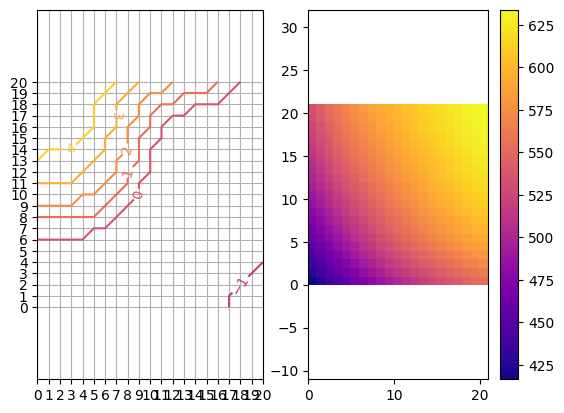

In [9]:
class PolicyIterationSolver(object):

    # Problem Parameters
    capacity = 20
    rental_reward = 10.0
    moving_cost = 2.0
    max_moving = 5
    bad_action_cost = 100.0  # Non-negative cost for bad actions (when bad_action_cost == 0, no punishment)
    
    # Request and return mean values for two locations
    request_mean_G1 = 3
    request_mean_G2 = 4
    return_mean_G1 = 3
    return_mean_G2 = 2

    discount = 0.9  # Discount factor
    PolicyEvaluationError = 0.01  # Threshold for policy evaluation convergence

    policy = None
    value = None

    def __init__(self):
        # Initialize the policy and value functions
        self.policy = np.zeros([self.capacity + 1] * 2, int)
        self.value = np.zeros([self.capacity + 1] * 2)
        
        # Compute expected rental rewards for each group
        self._reward1 = self.expected_rental_reward(self.request_mean_G1)
        self._reward2 = self.expected_rental_reward(self.request_mean_G2)
        
        # Validate that the bad_action_cost is non-negative
        assert self.bad_action_cost >= 0

    def bellman(self, action, s1, s2):
        # Compute the Bellman equation for the given action and states
        transp1 = self.transition_probability(s1, self.request_mean_G1, self.return_mean_G1, -action)
        transp2 = self.transition_probability(s2, self.request_mean_G2, self.return_mean_G2, action)
        transp = np.outer(transp1, transp2)

        return (self._reward1[s1] + self._reward2[s2] - 
                self.expected_moving_cost(s1, s2, action) + 
                self.discount * sum((transp * self.value).flat))

    def policy_evaluation(self):
        ''' Evaluate the policy while keeping it fixed and updating the value function. '''
        while True:
            diff = 0.0
            it = np.nditer([self.policy], flags=['multi_index'])

            while not it.finished:
                action = it[0]
                s1, s2 = it.multi_index

                # Save current value and calculate the new value
                _temp = self.value[s1, s2]
                self.value[s1, s2] = self.bellman(action=action, s1=s1, s2=s2)

                # Track the maximum change in value function
                diff = max(diff, abs(self.value[s1, s2] - _temp))

                it.iternext()

            print(diff)
            if diff < self.PolicyEvaluationError:
                break

    def policy_update(self):
        # Update the policy by selecting the best action for each state
        is_policy_changed = False
        it = np.nditer([self.policy], flags=['multi_index'])

        while not it.finished:
            s1, s2 = it.multi_index

            _max_val = -1
            _pol = None

            # Try all possible actions and select the one that maximizes the Bellman equation
            for act in range(-self.max_moving, self.max_moving + 1):
                _val = self.bellman(action=act, s1=s1, s2=s2)
                if _val > _max_val:
                    _max_val = _val
                    _pol = act

            # If the best action is different from the current policy, update it
            if self.policy[s1, s2] != _pol:
                is_policy_changed = True
                self.policy[s1, s2] = _pol

            it.iternext()

        return is_policy_changed

    def expected_moving_cost(self, s1, s2, action):
        # Calculate the expected moving cost based on the action
        if action == 0:
            return 0.0

        if action > 0:  # Moving from station 1 to station 2
            p = self.transition_probability(s1, self.request_mean_G1, self.return_mean_G1)
            cost = self._gen_move_cost_array(action)
            return cost.dot(p)

        # Moving from station 2 to station 1
        p = self.transition_probability(s2, self.request_mean_G2, self.return_mean_G2)
        cost = self._gen_move_cost_array(action)
        return cost.dot(p)

    def _gen_move_cost_array(self, action):
        ''' 
        Generate an array of costs for the movement of bikes.
        If the action exceeds available bikes, it is considered a bad action, which is penalized.
        '''
        _action = abs(action)

        # No penalty for bad actions
        if self.bad_action_cost == 0:
            cost = np.asarray([ii if ii < _action else _action for ii in range(self.capacity + 1)]) * self.moving_cost
        else:
            # Penalize bad actions
            cost = np.asarray([self.bad_action_cost if ii < _action else _action for ii in range(self.capacity + 1)]) * self.moving_cost

        return cost

    @classmethod
    def expected_rental_reward(cls, expected_request):
        # Calculate expected rental rewards for each state
        return np.asarray([cls._state_reward(s, expected_request) for s in range(cls.capacity + 1)])

    @classmethod
    def _state_reward(cls, s, mu):
        # Calculate state rewards using Poisson distribution
        rewards = cls.rental_reward * np.arange(s + 1)
        p = Poisson.pmf_series(mu, cutoff=s)
        return rewards.dot(p)

    def transition_probability(self, s, req, ret, action=0):
        ''' 
        Calculate the transition probabilities based on current state, request, return, and action.
        '''
        _ret_sz = self.max_moving + self.capacity

        p_req = Poisson.pmf_series(req, s)
        p_ret = Poisson.pmf_series(ret, _ret_sz)
        p = np.outer(p_req, p_ret)

        transp = np.asarray([p.trace(offset) for offset in range(-s, _ret_sz + 1)])

        # Ensure that the action does not exceed the maximum allowed
        assert abs(action) <= self.max_moving, f"Action can be no larger than {self.max_moving}."

        # No bikes are being moved
        if action == 0:
            transp[20] += sum(transp[21:])
            return transp[:21]

        # Move bikes from station 1 to station 2
        if action > 0:
            transp[self.capacity - action] += sum(transp[self.capacity - action + 1:])
            transp[self.capacity - action + 1:] = 0
            return np.roll(transp, shift=action)[:self.capacity + 1]

        # Move bikes from station 2 to station 1
        action = -action
        transp[action] += sum(transp[:action])
        transp[:action] = 0
        transp[action + self.capacity] += sum(transp[action + self.capacity + 1:])
        transp[action + self.capacity + 1:] = 0
        return np.roll(transp, shift=-action)[:self.capacity + 1]

    def policy_iteration(self):
        ''' 
        Policy iteration process. The situation where the policy oscillates between multiple equally good options is not handled.
        '''
        self.policy_evaluation()
        while self.policy_update():
            self.policy_evaluation()


# Solver instance
solver = PolicyIterationSolver()

# Iterate through the policy evaluation and update steps
for ii in range(4):
    solver.policy_evaluation()
    solver.policy_update()

# Output the final policy
print(solver.policy)

# Visualization using matplotlib
import matplotlib.pylab as plt

plt.subplot(121)
CS = plt.contour(solver.policy, levels=range(-6, 6), cmap='plasma')
plt.clabel(CS)
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.axis('equal')
plt.xticks(range(21))
plt.yticks(range(21))
plt.grid('on')

plt.subplot(122)
plt.pcolor(solver.value, cmap='plasma')
plt.colorbar()
plt.axis('equal')

plt.show()


### Problem 3

193.3490492751235
134.0042608644998
90.45243773749036
67.59779106615531
53.584930617584405
41.72086291128676
32.720109396858334
26.087556138177945
21.77814339269986
18.31805979033311
15.367406347702342
12.861027123617077
10.739286690815447
8.949004145273022
7.443128433756499
6.180206266078358
5.123897292162326
4.24254034724521
3.508736868355925
2.8989345554259103
2.3930120440830365
1.9738735796703963
1.6270638320043531
1.3404108007530908
1.1037016637392298
0.9083935811094648
0.7473592909606168
0.6146658513113152
0.5053839897119587
0.41542507105890536
0.3414025532433129
0.28051486211518295
0.23044680201445544
0.18928686930155436
0.15545811562628842
0.12766049026464543
0.10482286156792497
0.0860631678037862
0.0706553733336932
0.058002105893820044
0.047612025299258676
0.039081124729079875
0.03207729501525591
0.026327592373434072
0.021607743132278756
0.017733497475660442
0.014553510054838625
0.011943480427476061
0.009801332242602712
53.5173946458973
6.173467708643784
3.16695525354271
2.457

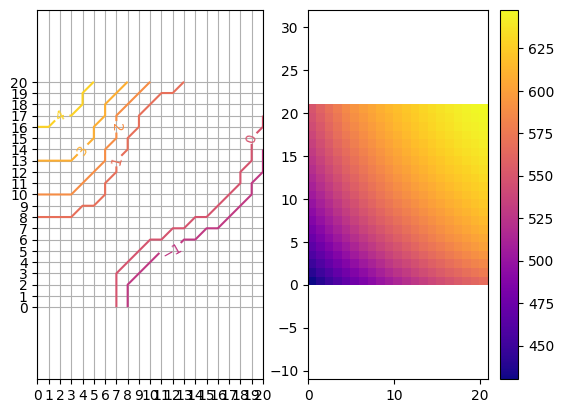

In [8]:
class PolicyIterationSolver:
    capacity = 20
    rental_reward = 10.0
    moving_cost = 2.0
    max_moving = 5
    parking_cost = 4.0

    # bad_action_cost should always be non-negative.
    # If bad_action_cost == 0, bad actions aren't penalized; otherwise, penalties are applied according to this value.
    bad_action_cost = 100.0

    request_mean_G1 = 3
    request_mean_G2 = 4
    return_mean_G1 = 3
    return_mean_G2 = 2

    discount = 0.9
    PolicyEvaluationError = 0.01

    policy = None
    value = None

    def __init__(self):
        self.policy = np.zeros([self.capacity + 1] * 2, int)
        self.value = np.zeros([self.capacity + 1] * 2)
        self._reward1 = self.expected_rental_reward(self.request_mean_G1)
        self._reward2 = self.expected_rental_reward(self.request_mean_G2)

        assert self.bad_action_cost >= 0

    def bellman(self, action, s1, s2):
        transp1 = self.transition_probabilty(s1, self.request_mean_G1, self.return_mean_G1, -action)
        transp2 = self.transition_probabilty(s2, self.request_mean_G2, self.return_mean_G2, action)
        transp = np.outer(transp1, transp2)

        return (self._reward1[s1] + self._reward2[s2] - 
                self.expected_moving_cost(s1, s2, action) + 
                self.discount * np.sum(transp * self.value))

    # Policy evaluation step
    def policy_evaluation(self):
        ''' Keep policy fixed and update value. '''
        while True:
            diff = 0.0
            it = np.nditer([self.policy], flags=['multi_index'])

            while not it.finished:
                action = it[0]
                s1, s2 = it.multi_index

                _temp = self.value[s1, s2]
                self.value[s1, s2] = self.bellman(action=action, s1=s1, s2=s2)
                diff = max(diff, abs(self.value[s1, s2] - _temp))
                it.iternext()

            print(diff)
            if diff < self.PolicyEvaluationError:
                break

    def policy_update(self):
        is_policy_changed = False
        it = np.nditer([self.policy], flags=['multi_index'])
        while not it.finished:
            s1, s2 = it.multi_index

            _max_val = -1
            _pol = None

            for act in range(-self.max_moving, self.max_moving + 1):
                _val = self.bellman(action=act, s1=s1, s2=s2)
                if _val > _max_val:
                    _max_val = _val
                    _pol = act

            if self.policy[s1, s2] != _pol:
                is_policy_changed = True
                self.policy[s1, s2] = _pol

            it.iternext()

        return is_policy_changed

    def expected_moving_cost(self, s1, s2, action):
        if action == 0:
            return 0.0

        if action > 0:
            p = self.transition_probabilty(s1, self.request_mean_G1, self.return_mean_G1)
            cost = self._gen_move_cost_array(action)
            if action > 10:
                cost += self.parking_cost * (action - 10)
            return cost.dot(p)

        p = self.transition_probabilty(s2, self.request_mean_G2, self.return_mean_G2)
        cost = self._gen_move_cost_array(action)
        if action > 10:
            cost += self.parking_cost * (action - 10)
        return cost.dot(p)

    def _gen_move_cost_array(self, action):
        '''
        Generate an array to calculate move costs.

        If action > available GBikes, it's considered a bad action.
        
        When self.bad_action_cost == 0, bad actions are not penalized; 
        When self.bad_action_cost > 0, bad actions are penalized as indicated by this variable.
        
        :param action: Number of GBikes moved from station 1 to station 2.
        :return: Array of moving costs.
        '''
        _action = abs(action)

        if _action != 0:
            _action -= 1

        if self.bad_action_cost == 0:
            cost = np.asarray([ii if ii < _action else _action for ii in range(self.capacity + 1)]) * self.moving_cost
        else:
            cost = np.asarray([self.bad_action_cost if ii < _action else _action for ii in range(self.capacity + 1)]) * self.moving_cost

        return cost

    @classmethod
    def expected_rental_reward(cls, expected_request):
        return np.asarray([cls._state_reward(s, expected_request) for s in range(cls.capacity + 1)])

    @classmethod
    def _state_reward(cls, s, mu):
        rewards = cls.rental_reward * np.arange(s + 1)
        p = Poisson.pmf_series(mu, cutoff=s)
        return rewards.dot(p)

    def transition_probabilty(self, s, req, ret, action=0):
        '''    
        :param s: Current state
        :param req: Mean value of requests
        :param ret: Mean value of returns
        :param action: Action (positive means move in, negative means move out)
        :return: Transition probability.
        '''

        _ret_sz = self.max_moving + self.capacity
        p_req = Poisson.pmf_series(req, s)
        p_ret = Poisson.pmf_series(ret, _ret_sz)
        p = np.outer(p_req, p_ret)

        transp = np.asarray([p.trace(offset) for offset in range(-s, _ret_sz + 1)])

        assert abs(action) <= self.max_moving, f"action cannot exceed {self.max_moving}."

        if action == 0:
            transp[20] += np.sum(transp[21:])
            return transp[:21]

        if action > 0:
            transp[self.capacity - action] += np.sum(transp[self.capacity - action + 1:])
            transp[self.capacity - action + 1:] = 0
            return np.roll(transp, shift=action)[:self.capacity + 1]

        action = -action
        transp[action] += np.sum(transp[:action])
        transp[:action] = 0

        transp[action + self.capacity] += np.sum(transp[action + self.capacity + 1:])
        transp[action + self.capacity + 1:] = 0

        return np.roll(transp, shift=-action)[:self.capacity + 1]

    def policy_iteration(self):
        ''' 
        Caveat: The situation where the policy keeps switching between two or more equally good policies isn't considered here.
        '''
        self.policy_evaluation()
        while self.policy_update():
            self.policy_evaluation()


# Solver initialization and iterations
solver = PolicyIterationSolver()

for _ in range(4):
    solver.policy_evaluation()
    solver.policy_update()

print(solver.policy)

# Visualization with matplotlib
import matplotlib.pylab as plt

plt.subplot(121)
CS = plt.contour(solver.policy, levels=range(-6, 6), cmap='plasma')
plt.clabel(CS)
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.axis('equal')
plt.xticks(range(21))
plt.yticks(range(21))
plt.grid(True)

plt.subplot(122)
plt.pcolor(solver.value, cmap='plasma')
plt.colorbar()
plt.axis('equal')

plt.show()
